In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import math
import time
from typing import List, Tuple, Union
import math as math 
import networkx as nx
from collections import deque

def compute_haversine(lat_long_tuple_1: tuple, lat_long_tuple_2: tuple) -> float:
    lat1, lon1 = lat_long_tuple_1
    lat2, lon2 = lat_long_tuple_2
    R_km = 6371.0088  # mean Earth radius in km
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R_km * c

def haversine_list_computer(initial_tuple, list):

    haversine_distance_list = []

    for i, entry in enumerate(list):
        haversine_distance_list.append(compute_haversine(initial_tuple, entry))

    return haversine_distance_list

def get_city_coordinates(city: str, state: str, country: str,
                         fallback: str = "nan") -> Tuple[float, float]:
    """
    Returns (latitude, longitude) of a given city, state, and country.
    
    If not found, returns:
        - (math.nan, math.nan) if fallback="nan"
        - (0.0, 0.0) if fallback="zero"
    """
    geolocator = Nominatim(user_agent="city-locator", timeout=10)
    query = f"{city}, {state}, {country}"
    location = geolocator.geocode(query)
    
    if location is None:
        if fallback == "nan":
            return (math.nan, math.nan)
        elif fallback == "zero":
            return (0.0, 0.0)
        else:
            raise ValueError("Invalid fallback option. Use 'nan' or 'zero'.")
    
    return (location.latitude, location.longitude)

def batch_get_coordinates(locations: List[Tuple[str, str, str]],
                          fallback: str = "nan",
                          pause: float = 0.1) -> List[Tuple[float, float]]:
    """
    Batch geocode a list of (city, state, country) tuples.
    Returns a list of (lat, lon) tuples.
    
    Parameters:
        locations : list of (city, state, country)
        fallback  : "nan" or "zero" for missing results
        pause     : seconds to wait between queries (default: 1.0, for Nominatim etiquette)
    """
    coords = []
    for city, state, country in locations:
        latlon = get_city_coordinates(city, state, country, fallback=fallback)
        coords.append(latlon)
        time.sleep(pause)  # be nice to the server
    return coords

def bfs(G, source):
    """ return a dictionary that maps node-->distance for all nodes reachable
        from the source node, in the unweighted undirected graph G """
    # set of nodes left to visit
    nodes = deque()
    nodes.append(source)
    
    # dictionary that gives True or False for each node
    visited = {node:False for node in G}
    visited[source] = True
    
    # Initial distances to source are: 0 for source itself, infinity otherwise
    dist = {node: np.inf for node in G}
    dist[source] = 0
    
    # while (container) is shorthand for "while this container is not empty"
    while nodes:
        # take the earliest-added element to the deque (why do we do this instead of popright?)
        node = nodes.popleft()
        
        # visit all neighbors unless they've been visited, record their distances
        for nbr in G.neighbors(node):
            if not visited[nbr]:
                dist[nbr] = dist[node] + 1
                visited[nbr] = True
                nodes.append(nbr)
    return dist

def components(G):
    """ return a list of tuples, where each tuple is the nodes in a component of G """
    components = []
    
    nodes_left = set(G.nodes())
    while nodes_left:
        src = nodes_left.pop()
        dist = bfs(G, src)
        component = tuple(node for node in dist.keys() if dist[node] < np.inf)
        components.append(component)
        nodes_left = nodes_left - set(component)
    return components
# results = batch_get_coordinates(cities, fallback="nan")
# for place, coord in zip(cities, results):
#     print(f"{place}: {coord}")



In [3]:
file_name = "ufo_sightings_cleaned.csv"
df = pd.read_csv(file_name, dtype=str)
data = df.to_numpy()

date_occurence_array = data.T[1]
city_array = data.T[2]
state_array = data.T[3]
country_array = data.T[4]
ufo_shape_array = data.T[5]
ufo_description_array = data.T[6]
date_reported_array = data.T[7]


In [4]:
dmy_occurence_array = []
clock_occurence_time_array = []

for i, entry in enumerate(date_occurence_array):
    dmy_occurence_array.append(entry.split(' ')[0])
    clock_occurence_time_array.append(entry.split(' ')[1])

In [5]:
minute_occurence_array = [] # in minutes
for i, clock in enumerate(clock_occurence_time_array):
    hour = int(clock.split(':')[0])
    minute = int(clock.split(':')[1])
    minute_occurence_array.append(hour*60 + minute)

minute_occurence_array = np.asarray(minute_occurence_array)
# print(minute_occurence_array)

In [6]:
minute_occurence_array_1 = []
for i, entry in enumerate(dmy_occurence_array):
    month, day, year = [int(x) for x in entry.split('/')]
    year_to_minutes = year * 525600
    month_to_minutes = month * 43800
    day_to_minutes = day * 1440
    minute_occurence_array_1.append(year_to_minutes + month_to_minutes + day_to_minutes)    

minute_occurence_array_1 = np.asarray(minute_occurence_array_1)

total_minute_occurence_array = minute_occurence_array + minute_occurence_array_1
print(total_minute_occurence_array)

[1064734950 1064732138 1064730510 ... 1022469240 1021984080 1017889800]


In [7]:
time_difference_matrix = np.zeros((len(total_minute_occurence_array), len(total_minute_occurence_array)))

for i, arr in enumerate(total_minute_occurence_array):
    a = np.asarray([abs(arr - j) for j in total_minute_occurence_array])
    time_difference_matrix[i, :] = a

print(time_difference_matrix)  

[[0.0000000e+00 2.8120000e+03 4.4400000e+03 ... 4.2265710e+07
  4.2750870e+07 4.6845150e+07]
 [2.8120000e+03 0.0000000e+00 1.6280000e+03 ... 4.2262898e+07
  4.2748058e+07 4.6842338e+07]
 [4.4400000e+03 1.6280000e+03 0.0000000e+00 ... 4.2261270e+07
  4.2746430e+07 4.6840710e+07]
 ...
 [4.2265710e+07 4.2262898e+07 4.2261270e+07 ... 0.0000000e+00
  4.8516000e+05 4.5794400e+06]
 [4.2750870e+07 4.2748058e+07 4.2746430e+07 ... 4.8516000e+05
  0.0000000e+00 4.0942800e+06]
 [4.6845150e+07 4.6842338e+07 4.6840710e+07 ... 4.5794400e+06
  4.0942800e+06 0.0000000e+00]]


In [8]:
shape_matrix = np.zeros((len(ufo_shape_array), len(ufo_shape_array)))

# print(ufo_shape_array)
for i, arr in enumerate(ufo_shape_array):
    a = np.asarray([0.05 if arr == ufo_shape_array[k] else 0 for k in range(len(ufo_shape_array))])
    shape_matrix[i, :] = a

print(shape_matrix)

[[0.05 0.   0.   ... 0.   0.   0.  ]
 [0.   0.05 0.   ... 0.   0.   0.  ]
 [0.   0.   0.05 ... 0.05 0.   0.05]
 ...
 [0.   0.   0.05 ... 0.05 0.   0.05]
 [0.   0.   0.   ... 0.   0.05 0.  ]
 [0.   0.   0.05 ... 0.05 0.   0.05]]


In [9]:
csc_list = []
for i in range(len(city_array)):
    csc_tuple = (city_array[i], state_array[i], country_array[i])
    csc_list.append(csc_tuple)

In [9]:
# lat_long_list = []
# for i in range(len(city_array)):
#     print(get_city_coordinates(city_array[i], state_array[i], country_array[i]))
#     lat_long_list.append(get_city_coordinates(city_array[i], state_array[i], country_array[i]))

In [10]:
latitude_list, longitude_list = np.genfromtxt("latitude_longitude_data.csv", delimiter=',', unpack=True)
lat_long_tuple_list = []
for i in range(len(latitude_list)):
    # print()
    lat_long_tuple_list.append((float(latitude_list[i]), float(longitude_list[i])))
print(lat_long_tuple_list)

[(41.1471616, -112.0548389), (34.0536909, -118.242766), (42.6411975, -72.4993421), (44.0903812, -66.2017536), (-27.4377187, 153.1659743), (40.5543106, -123.1830839), (43.1981117, -70.8739761), (-20.7619937, -45.9176017), (49.1913033, -122.849143), (36.2944928, -82.4734089), (39.049011, -95.677556), (22.8387354, 88.6245961), (29.1871986, -82.1400923), (31.2323437, 121.4691024), (42.5886235, -82.8217131), (43.6086295, -116.392326), (40.3350303, -104.9092844), (28.8644338, -80.8544975), (34.6677646, -120.114847), (44.9772995, -93.2654692), (32.8342952, -97.2289029), (40.3242526, -77.1730371), (29.5957696, -90.7195348), (42.1620186, -77.0941366), (40.6710765, -111.8250278), (29.0491426, -82.4609331), (44.6277071, -90.0086923), (47.1152695, -2.1040102), (35.9018987, -92.7098744), (46.49272, -80.991211), (42.9632425, -85.6678639), (36.06523, -119.0167679), (43.100231, -73.581963), (39.7085736, -105.0846694), (41.108604, -76.8972709), (43.5737361, -116.559631), (43.6166163, -116.200886), (36.

In [11]:
# Compute the full haversine distance matrix, where the i,j component is the distance between i and j, should be a symmetric matrix!!
haversine_matrix = np.zeros((len(lat_long_tuple_list), len(lat_long_tuple_list)))

for i, tuple in enumerate(lat_long_tuple_list):
    arr = haversine_list_computer(tuple, lat_long_tuple_list)
    haversine_matrix[i, :] = arr

In [12]:
weighting_function_haversine = lambda arr: 0.45*np.exp(-arr/200)
weighting_function_time = lambda arr: 0.5*np.exp(-arr/200)

total_weight_matrix = weighting_function_haversine(haversine_matrix) + weighting_function_time(time_difference_matrix) + shape_matrix

for i in range(len(total_weight_matrix)):
    total_weight_matrix[i][i] = 0


In [13]:
from networkx.algorithms import approximation as apx

ufo_labels = [i for i in range(1, 1476)]
ufo_network = nx.Graph()

ufo_network.add_nodes_from(ufo_labels)
# print(ufo_network)

for i, start_node in enumerate(ufo_labels):
    for j, end_node in enumerate(ufo_labels):
        ufo_network.add_edge(start_node, end_node, weight = total_weight_matrix[i][j])
print("Initial network attributes:")
print(ufo_network)
for i, node in enumerate(ufo_labels):
    for j, secondary_node in enumerate(ufo_labels):
        if ufo_network.has_edge(node, secondary_node) and ufo_network.edges[node, secondary_node]['weight'] < 1e-1:
                ufo_network.remove_edge(node, secondary_node)
print()
print("Current network attributes:")
print(ufo_network)
print("The average degree of the network is: ", np.mean([ufo_network.degree(node) for node in ufo_network]))   

Initial network attributes:
Graph with 1475 nodes and 1088550 edges

Current network attributes:
Graph with 1475 nodes and 201756 edges
The average degree of the network is:  273.56745762711864


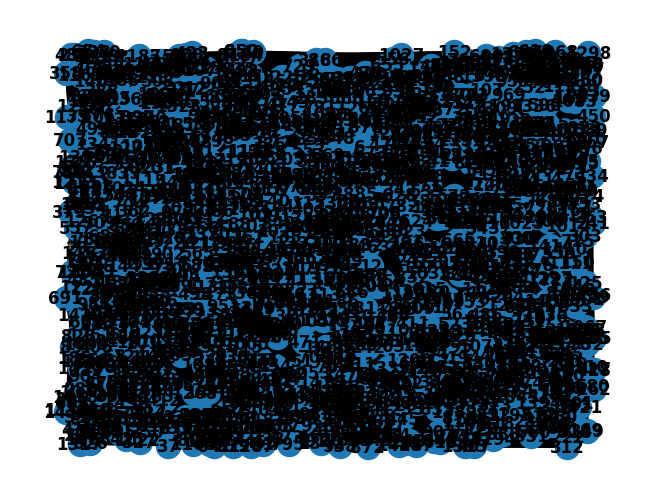

In [15]:
nx.draw(ufo_network, with_labels=True, font_weight='bold')


In [14]:
C = components(ufo_network)
print("The number of connected components is:", len(C))

C = sorted(C, key=lambda c: len(c), reverse=True)
component_sizes = [len(c) for c in C]
# print(component_sizes)
for i, size in enumerate(C):
    print(f"Component {i+1} has size = {len(size)}")

TypeError: 'tuple' object is not callable

In [158]:
print(nx.adjacency_matrix(ufo_network).toarray())

[[ 0.  0.  0. ... nan  0.  0.]
 [ 0.  0.  0. ... nan  0.  0.]
 [ 0.  0.  0. ... nan  0.  0.]
 ...
 [nan nan nan ...  0. nan nan]
 [ 0.  0.  0. ... nan  0.  0.]
 [ 0.  0.  0. ... nan  0.  0.]]
